# Assignment 2 Starter Notebook (TensorFlow/Keras)
## Training Deep Neural Networks: Initialization, Regularization, and Optimization (Week 3)

**Lectures covered:** Week 3 (gradient flow, Xavier/He init, L2/Dropout/BatchNorm, SGD/Momentum, Adam/RMSProp/Adagrad)

**Dataset:** UCI Adult Income (1994 U.S. Census) via OpenML

> This notebook is a starter template. Complete all **TODO** sections and keep experiments controlled (change one factor at a time).


In [1]:
# === Imports ===
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2026-02-10 13:12:14.783402: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-10 13:12:14.783613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-10 13:12:14.964426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-10 13:12:15.314417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-10 13:12:19.702020: W tensorflow/comp

In [2]:
# === Reproducibility ===
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)

TensorFlow: 2.15.1


## Q1. Dataset Loading (Ungraded)

### Load Adult Income Dataset (OpenML)

This cell loads the **Adult (Census Income)** dataset from OpenML using `fetch_openml` and separates features and labels.  
- **X** contains the input features (demographic and employment attributes).  
- **y** contains the target labels indicating whether annual income is **>50K** or **≤50K**.  
The shapes and a preview of the feature table are printed for quick inspection.


In [3]:
# Required access method:
adult = fetch_openml(name="adult", version=2, as_frame=True)

X = adult.data
y = adult.target  # strings: '>50K' or '<=50K'

print("X shape:", X.shape)
print("y shape:", y.shape)
X.head()

X shape: (48842, 14)
y shape: (48842,)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States


## ✅ Student Instructions (Start Here)

Your work begins in the **next code cells (Q2–Q10)** and continues by answering questions in the **Markdown cells (Q11–Q14)**. These correspond to the questions listed in the assignment description on Canvas. Complete each cell by following the instructions provided in the **preceding Markdown cells**.

Please:
- **Read the instructions carefully** before you begin coding.
- Take time to **understand each question** and implement the required steps.
- Each code cell includes **partial starter code**—your task is to **fill in the missing parts** and ensure the cell runs correctly.

If you need clarification at any point, please contact the **teaching staff (instructor/TA)** for support.


## Q2. Train/Validation/Test split

### Train / Validation / Test Split (Stratified)

In this step, you will split the dataset into **training (60%)**, **validation (20%)**, and **test (20%)** sets.

- Use a **two-stage split** to achieve the 60/20/20 ratio.
- Apply **stratification by the target label** to preserve the original class distribution in all splits.
- Fix the **random seed (`SEED`)** to ensure reproducibility.
- Print the shapes of each split to verify that the proportions are correct.

This split allows you to train the model on the training set, tune hyperparameters using the validation set, and report final performance on the unseen test set.


In [4]:
# TODO: Use a 60/20/20 split (train/val/test), stratified by label.

# Step 1: Split the data into training (60%) and temporary (40%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4 ,            # TODO: fraction for validation+test
    random_state=SEED ,         # TODO: set the random seed
    stratify=y               # TODO: stratify by the target labels
)

# Step 2: Split the temporary set equally into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5 ,            # TODO: fraction for test split
    random_state=SEED ,         # TODO: set the same random seed
    stratify=y_temp               # TODO: stratify by the temporary labels
)

# Verify split sizes
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (29305, 14) Val: (9768, 14) Test: (9769, 14)


## Q3. Preprocessing (one-hot encode categoricals; scale numericals)

### Feature Engineering & Preprocessing (What You Should Do)

In this step, you will prepare the dataset for machine learning by handling **categorical and numerical features appropriately**.

You should:
- **Identify categorical and numerical columns** in the training set using data types.
- Apply **One-Hot Encoding (OHE)** to categorical features, ensuring unseen categories are safely handled.
- Apply **Standard Scaling** to numerical features so they are on a comparable scale.
- Use a **ColumnTransformer** to combine these preprocessing steps into a single pipeline.
- **Fit the preprocessing pipeline only on the training data**, then use it to transform the validation and test sets (to avoid data leakage).
- **Encode the target labels** into binary values `{0, 1}`, where `1` corresponds to income `>50K`.

Finally, verify your work by printing the **processed feature shapes** for the training, validation, and test sets.


In [5]:
# TODO: Identify categorical and numerical feature columns from the training set
cat_cols = X_train.select_dtypes(include=['object' , 'category']).columns.tolist()

num_cols = X_train.select_dtypes(exclude=['object' , 'category']).columns.tolist()

print("Categorical columns:", len(cat_cols))
print("Numeric columns:", len(num_cols))


# TODO: Build a preprocessing pipeline
# - Apply StandardScaler to numerical features
# - Apply OneHotEncoder to categorical features

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),   # TODO: scaler for numerical columns
        ("cat", OneHotEncoder(
            handle_unknown="ignore",
            sparse_output=False        # TODO: return dense output
        ), cat_cols),
    ],
    remainder='drop'                  # TODO: drop unused columns
)


# TODO: Fit preprocessing on TRAIN only, then transform all splits
X_train_p = preprocess.fit_transform(X_train)
X_val_p   = preprocess.transform(X_val)
X_test_p  = preprocess.transform(X_test)


# TODO: Encode labels into {0, 1}
# 1 corresponds to income >50K
y_train_i = (y_train == "50k").astype("int32").to_numpy()
y_val_i   = (y_val   == "50k").astype("int32").to_numpy()
y_test_i  = (y_test  == "50k").astype("int32").to_numpy()

# Verify processed feature shapes
print("Processed shapes:", X_train_p.shape, X_val_p.shape, X_test_p.shape)


Categorical columns: 8
Numeric columns: 6
Processed shapes: (29305, 108) (9768, 108) (9769, 108)


## Q4. Deep MLP definition (≥ 6 hidden layers)

### Build a Deep MLP Model (What You Should Do)

In this step, you will **construct a deep multilayer perceptron (MLP)** for binary classification using Keras.

You should:
- Use the provided `build_deep_mlp` function to **define a configurable deep neural network**.
- Specify the **input dimension** based on the number of preprocessed features.
- Control the **model depth and width** to create a deep architecture suitable for the task.
- Optionally enable **Batch Normalization, Dropout, and L2 regularization** to improve training stability and generalization.
- Ensure the **final output layer** uses a sigmoid activation for binary classification.

After building the model:
- Call `model.summary()` to **inspect the network architecture**, including layer types, output shapes, and number of trainable parameters.

This step helps you understand how architectural choices (depth, width, regularization) affect deep neural network design.


In [6]:
# TODO: Complete the deep MLP builder with configurable depth, width, and regularization

def build_deep_mlp(
    input_dim: int,
    depth: int = 8,                     # TODO: number of hidden layers
    width: int = 16,                     # TODO: number of units per layer
    activation: str = "relu",                # TODO: hidden-layer activation
    kernel_initializer: str | keras.initializers.Initializer = "random_normal",
    use_batchnorm: bool = True,             # TODO: enable/disable BatchNorm
    dropout_rate: float = 0.3,             # TODO: dropout probability
    l2_weight: float = 0.01,                # TODO: L2 regularization strength
) -> keras.Model:
    """Deep MLP for binary classification with configurable init, BN, dropout, and L2."""

    # TODO: Add L2 regularization only if l2_weight > 0
    reg = keras.regularizers.L2(l2_weight) if l2_weight and l2_weight > 0 else None

    # TODO: Define model input
    inputs = keras.Input(shape=(input_dim ,))
    x = inputs

    # TODO: Build hidden layers
    for _ in range(depth):
        x = layers.Dense(
            width,                           # TODO: layer width
            activation=None,               # TODO: no activation here
            kernel_initializer=kernel_initializer,
            kernel_regularizer=reg ,
        )(x)

        # TODO: Optional Batch Normalization
        if use_batchnorm:
            x = layers.BatchNormalization()(x)

        # TODO: Apply activation
        x = layers.Activation(activation)(x)

        # TODO: Optional Dropout
        if dropout_rate and dropout_rate > 0:
            x = layers.Dropout (dropout_rate)(x)

    # TODO: Output layer for binary classification
    outputs = layers.Dense(1, activation="sigmoid")(x)

    # TODO: Build and return the model
    model = keras.Model(inputs, outputs)
    return model

# function call- do not change
input_dim = X_train_p.shape[1]
deep_model = build_deep_mlp(input_dim=input_dim, depth=6, width=256)
deep_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 108)]             0         
                                                                 
 dense (Dense)               (None, 256)               27904     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                             

## Q5. Gradient flow diagnostics (vanishing/exploding)

### Measure Vanishing/Exploding Gradients (What You Should Do)

In this step, you will **diagnose gradient behavior** in a deep MLP by computing **layer-wise gradient norms**.

You should:
- Use the provided helper function `layerwise_grad_norms(...)` to compute:
  - the **batch loss**, and  
  - the **L2 norm of the gradient** for each Dense layer’s **kernel weights**.
- Create a small mini-batch (`BATCH = 512`) from the preprocessed training data.
- Build a deep model using a **clearly “naïve” weight initialization** (e.g., `RandomNormal(stddev=1.0)`), which can increase the risk of unstable gradients.
- Run one forward pass to ensure the model weights are created, then compute and print:
  - the **initial batch loss**
  - the **gradient norms** for early layers (and optionally all layers)

**Your key task for analysis:**
- During training (across epochs), **record these gradient norms** and observe whether they:
  - shrink toward zero (**vanishing gradients**), or
  - grow very large (**exploding gradients**),
  especially in earlier layers.

You will use these observations in your written answers to explain *why* training becomes difficult in deep networks and *how* techniques like better initialization, BatchNorm, or residual connections can help.


In [13]:
# TODO: Complete the utility that computes layer-wise gradient norms for Dense kernels

def layerwise_grad_norms(model: keras.Model, x_batch, y_batch):
    # TODO: convert x_batch to a float32 tensor
    x_batch = tf.convert_to_tensor(x_batch, dtype="f")

    # TODO: reshape y_batch to (N, 1) and convert to float32 tensor
    y_batch = tf.convert_to_tensor(y_batch.reshape(-1, _____), dtype="f")

    # TODO: compute loss under a GradientTape context
    with tf.GradientTape() as tape:
        y_pred = model(x_batch, training=True)   # TODO: training flag
        loss = keras.losses.binary_crossentropy(y_batch, y_pred)  # TODO: binary cross-entropy
        loss = tf.reduce_mean(_____)

    # TODO: compute gradients of loss w.r.t. trainable variables
    grads = tape.gradient(_____, model.trainable_variables)

    # TODO: collect gradient norms for Dense layer kernels only
    norms = []
    names = []
    for var, g in zip(model.trainable_variables, grads):
        if g is None:
            continue
        if "dense" in var.name and "kernel" in var.name:
            norms.append(float(tf.norm(_____)))   # TODO: gradient tensor
            names.append(_____ )                  # TODO: variable name

    return float(loss), names, norms


# TODO: Prepare a mini-batch for gradient diagnostics
BATCH = _____
x_b = X_train_p[:_____]
y_b = y_train_i[:_____]


# TODO: Create a model with a clearly "naïve" initialization for Q1
naive_init = keras.initializers.RandomNormal(
    mean=_____,
    stddev=_____,
    seed=_____
)

model_naive = build_deep_mlp(
    input_dim=_____,
    depth=_____,
    width=_____,
    activation=_____,
    kernel_initializer=_____
)

# TODO: Run a forward pass once to build weights
_ = model_naive(tf.convert_to_tensor(_____, dtype=_____))

# function call- do not change
loss0, names0, norms0 = layerwise_grad_norms(model_naive, x_b, y_b)
print("Initial batch loss:", loss0)
for n, v in list(zip(names0, norms0))[:6]:
    print(n, "->", v)


NameError: name '_____' is not defined

## Q6. Initialization study (Xavier vs He)

### Compare Xavier vs. He Initialization (What You Should Do)

In this step, you will **train two deep MLP models under controlled settings** to compare how different weight initializations affect learning.

You should:
- Use `compile_model(...)` to compile each model with:
  - **binary cross-entropy** loss
  - **binary accuracy** metric
  - the **same optimizer** (SGD) and learning rate for a fair comparison
- Train both models using `fit_model(...)` with the same:
  - number of epochs (e.g., 20)
  - batch size (e.g., 256)

Models to compare:
- **Xavier/Glorot initialization** with **tanh** activation  
- **He initialization** with **ReLU** activation  

After training:
- Plot and compare **validation loss vs. epoch** for both models.
- Interpret which combination converges faster and achieves lower validation loss.


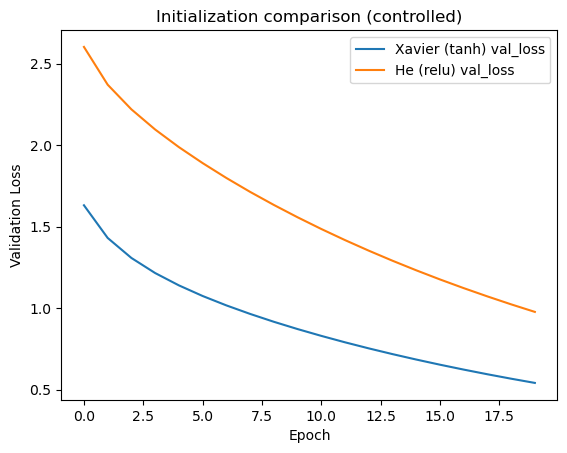

In [7]:
# TODO: Complete helper functions to compile and train a Keras model

def compile_model(model: keras.Model, optimizer: keras.optimizers.Optimizer):
    model.compile(
        optimizer='SGD',                         # TODO: pass the optimizer
        loss='binary_crossentropy',                              # TODO: binary classification loss
        metrics=[keras.metrics.Accuracy(name="accuracy")  # TODO: accuracy metric + name
               ]
    )
    return model


def fit_model(model: keras.Model, epochs: int = 20, batch_size: int = 256):
    history = model.fit(
        X_train_p, y_train_i,                            # TODO: training features and labels
        validation_data=(X_val_p, y_val_i),           # TODO: validation features and labels
        epochs=epochs,
        batch_size=batch_size,
        verbose=0                            # TODO: 0 for silent training
    )
    return history


# TODO: Define Xavier (Glorot) and He initializations
xavier = keras.initializers.GlorotNormal(seed=SEED)
he     = keras.initializers.HeNormal(seed=SEED)


# TODO: Build + compile two controlled models:
# 1) Xavier + tanh, 2) He + ReLU. Use the same optimizer type and learning rate.
model_xavier = compile_model(
    build_deep_mlp(
        input_dim=X_train_p.shape[1],
        depth=8,
        width=16,
        activation='tanh',                        # TODO: tanh
        kernel_initializer=xavier
    ),
    keras.optimizers.SGD(learning_rate=0.01)  # TODO: SGD and lr
)

model_he = compile_model(
    build_deep_mlp(
        input_dim=X_train_p.shape[1],
        depth=8,
        width=16,
        activation='relu',                        # TODO: relu
        kernel_initializer=he
    ),
    keras.optimizers.SGD(learning_rate=0.01)  # TODO: same optimizer and lr
)

# function call- do not change
hist_xavier = fit_model(model_xavier, epochs=20)
hist_he = fit_model(model_he, epochs=20)

plt.figure()
plt.plot(hist_xavier.history["val_loss"], label="Xavier (tanh) val_loss")
plt.plot(hist_he.history["val_loss"], label="He (relu) val_loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Initialization comparison (controlled)")
plt.show()


## Q7. Regularization study (L2 and Dropout)

### Regularization Experiments: L2 Weight Decay vs. Dropout (What You Should Do)

In this step, you will test how **regularization** affects overfitting and generalization in a deep MLP.

You should:
- **Choose ONE best initialization from Q2** (Xavier or He) and keep it fixed for all experiments here to ensure a fair comparison.
  - Update `base_init = ...` based on your Q2 results.

Then run two controlled studies:

**1) L2 Weight Decay (Kernel Regularizer)**
- Train two models with different L2 strengths:
  - `l2_weight = 1e-4`
  - `l2_weight = 1e-3`
- Keep architecture, optimizer, learning rate, epochs, and batch size the same.

**2) Dropout**
- Train two models with different dropout rates:
  - `dropout_rate = 0.2`
  - `dropout_rate = 0.5`
- Keep everything else the same as in the L2 study.

After training:
- Plot **validation loss vs. epoch** for all four models on the same figure.



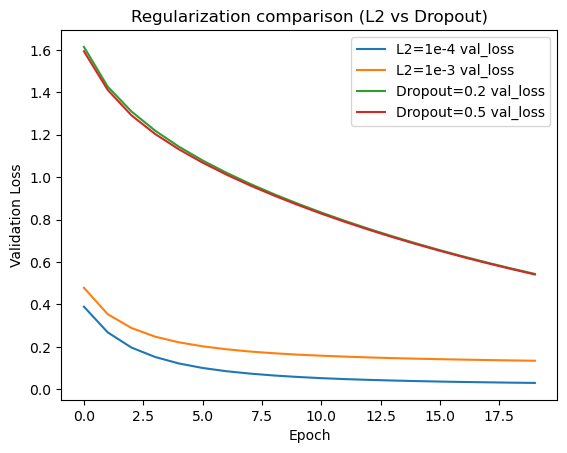

In [8]:
# TODO: Regularization Experiments — L2 Weight Decay and Dropout

# TODO: Choose ONE best initialization from Q2 and keep it fixed
base_init = xavier


# =========================
# L2 Weight Decay Study
# =========================

model_l2_1 = compile_model(
    build_deep_mlp(
        input_dim=X_train_p.shape[1],
        depth=8,
        width=16,
        activation='tanh',                 # TODO: activation function
        kernel_initializer=base_init,
        l2_weight=1e-4                   # TODO: smaller L2 value (e.g., 1e-4)
    ),
    keras.optimizers.SGD(              # TODO: optimizer type
        learning_rate=0.01,
        momentum=0.0                   # TODO: momentum value
    )
)

model_l2_2 = compile_model(
    build_deep_mlp(
        input_dim=X_train_p.shape[1],
        depth=8,
        width=16,
        activation='tanh',
        kernel_initializer=base_init,
        l2_weight=1e-3                   # TODO: larger L2 value (e.g., 1e-3)
    ),
    keras.optimizers.SGD(
        learning_rate=0.01,
        momentum=0.0
    )
)

# function call- do not change
hist_l2_1 = fit_model(model_l2_1, epochs=20)
hist_l2_2 = fit_model(model_l2_2, epochs=20)


# =========================
# Dropout Study
# =========================

model_do_1 = compile_model(
    build_deep_mlp(
        input_dim=X_train_p.shape[1],
        depth=8,
        width=16,
        activation='tanh',
        kernel_initializer=base_init,
        dropout_rate=0.2               # TODO: moderate dropout (e.g., 0.2)
    ),
    keras.optimizers.SGD(
        learning_rate=0.01,
        momentum=0.0
    )
)

model_do_2 = compile_model(
    build_deep_mlp(
        input_dim=X_train_p.shape[1],
        depth=8,
        width=16,
        activation='tanh',
        kernel_initializer=base_init,
        dropout_rate=0.5               # TODO: stronger dropout (e.g., 0.5)
    ),
    keras.optimizers.SGD(
        learning_rate=0.01,
        momentum=0.0
    )
)

# function call- do not change
hist_do_1 = fit_model(model_do_1, epochs=20)
hist_do_2 = fit_model(model_do_2, epochs=20)

plt.figure()
plt.plot(hist_l2_1.history["val_loss"], label="L2=1e-4 val_loss")
plt.plot(hist_l2_2.history["val_loss"], label="L2=1e-3 val_loss")
plt.plot(hist_do_1.history["val_loss"], label="Dropout=0.2 val_loss")
plt.plot(hist_do_2.history["val_loss"], label="Dropout=0.5 val_loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Regularization comparison (L2 vs Dropout)")
plt.show()


## Q8. Batch Normalization study

### Batch Normalization Experiment (What You Should Do)

In this step, you will evaluate how **Batch Normalization (BN)** affects training stability and convergence in a deep MLP.

You should:
- Keep the setup **controlled and consistent**:
  - Use the same **base initialization** (`base_init`) you selected earlier.
  - Use the same **optimizer and learning rate** (SGD, `lr=1e-2`, no momentum).
  - Use the same architecture (depth, width, activation).

Train two models:
- **With BatchNorm**: `use_batchnorm=True`
- **Without BatchNorm**: `use_batchnorm=False`

After training:
- Plot **validation loss vs. epoch** for both models on the same figure.
- Compare which model:
  - converges faster,
  - has smoother/more stable learning,
  - achieves better final validation loss.


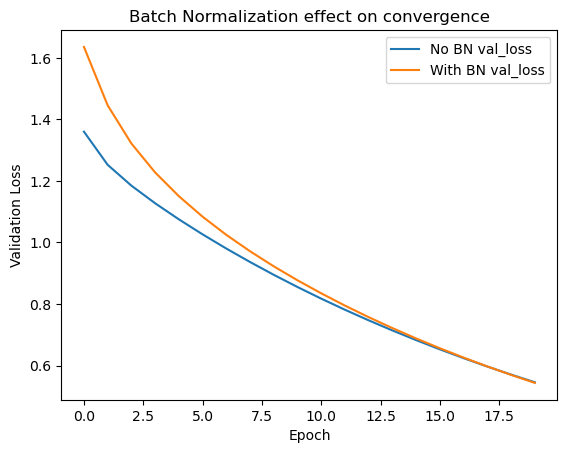

In [9]:
# TODO: BatchNorm Experiment — keep initialization + optimizer controlled

# Build + compile model WITH Batch Normalization
model_bn = compile_model(
    build_deep_mlp(
        input_dim=X_train_p.shape[1],
        depth=8,
        width=16,
        activation='tanh',                  # TODO: activation function
        kernel_initializer=base_init,          # TODO: base_init
        use_batchnorm=True                # TODO: enable BN
    ),
    keras.optimizers.SGD(
        learning_rate=1e-2,
        momentum=0.0                     # TODO: keep momentum fixed
    )
)

# Build + compile model WITHOUT Batch Normalization
model_no_bn = compile_model(
    build_deep_mlp(
        input_dim=X_train_p.shape[1],
        depth=8,
        width=16,
        activation='tanh',
        kernel_initializer=base_init,
        use_batchnorm=False                # TODO: disable BN
    ),
    keras.optimizers.SGD(
        learning_rate=1e-2,
        momentum=0.0
    )
)

# function call- do not change
hist_bn = fit_model(model_bn, epochs=20)
hist_no_bn = fit_model(model_no_bn, epochs=20)

plt.figure()
plt.plot(hist_no_bn.history["val_loss"], label="No BN val_loss")
plt.plot(hist_bn.history["val_loss"], label="With BN val_loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Batch Normalization effect on convergence")
plt.show()


## Q9. Optimizer study (SGD vs Momentum vs Adaptive)

### Optimizer Comparison: SGD vs. Momentum vs. Adam (What You Should Do)

In this step, you will compare how different **optimization algorithms** affect training and validation performance.

You should:
- Keep the experiment **fair and controlled** by fixing:
  - the **same architecture** (depth, width, activation)
  - the **same initialization** (`base_init`)
  - BatchNorm setting (here: `use_batchnorm=False`)
- Train three models using different optimizers:
  - **SGD** (learning rate `1e-2`, momentum `0.0`)
  - **SGD + Momentum** (learning rate `1e-2`, momentum `0.9`)
  - **Adam** (learning rate `1e-3`)

After training:
- Plot **validation loss vs. epoch** for all optimizers on the same figure.
- Compare which optimizer reaches low validation loss faster and which is more stable.


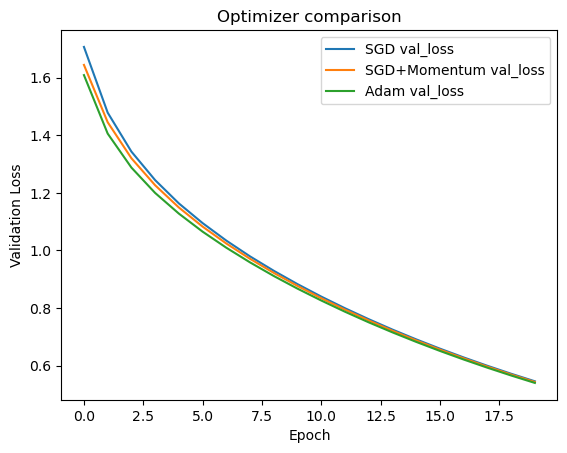

In [10]:
# TODO: Optimizer Comparison — keep architecture + initialization fixed

# TODO: Create a shared architecture config dictionary (same for all optimizers)
arch_kwargs = dict(
    input_dim=X_train_p.shape[1],
    depth=8,
    width=16,
    activation='tanh',
    kernel_initializer=base_init,      # TODO: base_init from earlier
    use_batchnorm=True            # TODO: keep BN fixed (True or False)
)

# TODO: Build + compile models with different optimizers (architecture must be identical)

model_sgd = compile_model(
    build_deep_mlp(**arch_kwargs),
    keras.optimizers.SGD(
        learning_rate=1e-2,
        momentum=0.0
    )
)

model_mom = compile_model(
    build_deep_mlp(**arch_kwargs),
    keras.optimizers.SGD(
        learning_rate=1e-2,
        momentum=0.9
    )
)

model_adam = compile_model(
    build_deep_mlp(**arch_kwargs),
    keras.optimizers.Adam(
        learning_rate=1e-3
    )
)

# function call- do not change
hist_sgd = fit_model(model_sgd, epochs=20)
hist_mom = fit_model(model_mom, epochs=20)
hist_adam = fit_model(model_adam, epochs=20)

plt.figure()
plt.plot(hist_sgd.history["val_loss"], label="SGD val_loss")
plt.plot(hist_mom.history["val_loss"], label="SGD+Momentum val_loss")
plt.plot(hist_adam.history["val_loss"], label="Adam val_loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Optimizer comparison")
plt.show()


## Q10. Final evaluation (test set)

### Final Model Selection & Evaluation (What You Should Do)

In this step, you will **select the best-performing model** from your previous controlled experiments and evaluate its performance.

You should:
- Review results from all prior experiments (initialization, regularization, BatchNorm, optimizers).
- **Choose ONE final model** that demonstrates the best balance of:
  - stable convergence,
  - low validation loss,
  - good generalization.
- Assign this model to `final_model`.

Then:
- Use the provided `evaluate(...)` function to compute performance on:
  - the **validation set**, and
  - the **held-out test set**.
- Report both **loss** and **accuracy**.

In [12]:
def evaluate(model: keras.Model, X, y):
    y = y.reshape(-1, 1).astype("float32")
    return dict(zip(model.metrics_names, model.evaluate(X, y, verbose=0)))

# TODO: Choose the best model based on your controlled experiments.
final_model = model_adam

val_results = evaluate(final_model, X_val_p, y_val_i)
test_results = evaluate(final_model, X_test_p, y_test_i)

print("Validation:", val_results)
print("Test:", test_results)

Validation: {'loss': 0.5381256341934204, 'compile_metrics': 0.8347665667533875}
Test: {'loss': 0.559341311454773, 'compile_metrics': 0.8413348197937012}


In [ ]:
# TODO: Complete the evaluation utility and final model selection

def evaluate(model: keras.Model, X, y):
    # TODO: reshape labels to (N, 1) and cast to float32
    y = y.reshape(-1, _____).astype('f')

    # TODO: evaluate the model silently and return a dictionary of metrics
    return dict(
        zip(
            model._____,                   # TODO: metric names
            model.compile(X, y, verbose=0)
        )
    )


# TODO: Select the best-performing model based on your controlled experiments
# (initialization, regularization, BatchNorm, and optimizer)
final_model = _____


# TODO: Evaluate the final model on validation and test sets
val_results  = evaluate(_____, _____, _____)
test_results = evaluate(_____, _____, _____)

print("Validation:", val_results)
print("Test:", test_results)


## Results & Discussion (Answer Each Question Clearly)

- **Review and answer the following questions carefully briefly**


## Q11. Gradient Behavior Analysis 

From the gradient‐norm computation code, do gradients in early layers **vanish, explode, or remain stable** for naïve initialization compared to Xavier/He? State your conclusion using observed gradient norms.

**Type your answer:** 

---


## Q12. Initialization and Convergence  

Based on the validation-loss curves for Xavier (tanh) and He (ReLU) initializations, compare their convergence speed and final performance. Which combination performed better in this deep MLP, and why is this result theoretically expected?

**Type your answer:**

---

## Q13. Regularization and Generalization  

Analyze the effects of L2 weight decay and Dropout on training and validation performance. How did different regularization strengths affect overfitting, convergence, and validation loss? Which regularization setting provided the best generalization, and why?

**Type your answer:**

---

## Q14. Optimization and Training Stability

Compare the behavior of SGD, SGD with momentum, and Adam using the validation-loss curves. Discuss differences in convergence speed, stability, and generalization. How did Batch Normalization interact with these optimizers to influence training dynamics?

**Type your answer:**


---

### 🎉 Congratulations!

You have successfully completed **Assignment 2**. Excellent work engaging with core concepts in **deep neural networks**, including **gradient behavior**, **weight initialization**, **regularization**, **batch normalization**, and **optimization strategies** for training multi-layer perceptrons.

### **Submission Instructions**

Please submit a **GitHub repository link** on Canvas that contains:
- The **completed Jupyter notebook**
- Any additional files required for the assignment (if applicable)

Before submitting, ensure that:
- All **code cells (Q2–Q10)** have been executed successfully
- All **Markdown responses (Q11–Q14)** have been completed
- The notebook is **saved after execution** so that outputs are visible

Once verified, **push the final version to GitHub** and submit the repository link on Canvas.
